In [2]:
import numpy as np
import matplotlib.pyplot as plt
import functools as ft
from scipy.linalg import expm
from scipy.stats import unitary_group
from itertools import permutations

# Investigating the 'new ensemble'

The new ensemble is formed as follows: for an ensemble of pure states $\{p_m, \ket{\psi_m} \}$, with moments $\mathcal{F}^{(k)} = \sum_m p_m \ket{\psi_m} \bra{\psi_m} ^{\otimes k}$, with error probability $r$ we can form the ensemble $\{p_m, (1-r) \ket{\psi_m} \bra{\psi_m} + r \mathcal{F}^{(1)} \}$. The 'new ensemble' is then this ensemble in the limit of the ensemble of pure states tending to the Haar random ensemble.

### Functions #1
Here we have the Quantum Ising Mixed Field Hamiltonian following Cotler et al., a function to extract a projected ensemble on $A$ from a generic state on $AB$, and a function to obtain the ensemble of mixed states ('mixed ensemble') in the case of faulty measurement, with independent bitflip error $q$ everywhere.

In [3]:
# Parameters
sx = np.array([[0,1],[1,0]]) ;  sy = np.array([[0,-1j],[1j,0]])

def QIMF(N, h_x, h_y, J):

    # Single site term
    H1 = h_x * sx + h_y * sy
    # Interaction term
    H2 = J * np.kron(sx,sx)

    # Hamiltonian as a matrix
    H = np.zeros((2**N,2**N),dtype='complex128')
    for i in range(N):
        H += ft.reduce(np.kron, [np.identity(2**i), H1, np.identity(2**(N-i-1))])
    for i in range(N-2):
        H += ft.reduce(np.kron, [np.identity(2**i), H2, np.identity(2**(N-i-2))])
    
    return H

def random_state(d):
    '''Produces a Haar random state in d-dimensional Hilbert space as a numpy array.'''
    U = unitary_group.rvs(d)
    psi0 = np.zeros(d, dtype='complex128')
    psi0[0] = 1
    
    return U @ psi0

def Hamming(str_a, str_b):
    '''Returns the Hamming distance of two equal length strings'''
    Hamming = 0
    for i in range(len(str_a)):
        if str_a[i] != str_b[i]:
            Hamming += 1
    return Hamming

def error_prob(m, m_prime, N_B, q):
    '''
    For single independent bitflip errors with probability p, returns the probability of reading m_prime for a true outcome m,
    for m and m_prime input as base-10 integers between 0 and 2**N_B.
    '''
    str_m = format(m, f'0{N_B}b')
    str_m_prime = format(m_prime, f'0{N_B}b')
    num_errors = Hamming(str_m, str_m_prime)
    prob = (q ** num_errors) * ((1-q) ** (N_B - num_errors))

    return prob

# From previous work: get projected ensemble on A from a state in AB
def Get_PrEns(Psi, N_A, N_B):
    PrEns = np.empty((2**N_B, 2)).tolist()

    for i in range(2**N_B):
        PsiA = Psi.reshape(2**N_A, 2**N_B)[:,i]
        PrEns[i][0] = np.linalg.norm(PsiA) ** 2
        PrEns[i][1] = PsiA / np.linalg.norm(PsiA)
    
    return PrEns

def Get_MixEns(PrEns, N_A, N_B, q):
    '''From a pure ensemble, return a mixed ensemble given an independent bitflip error p'''
    MixEns = np.empty((2 ** N_B, 2)).tolist()

    for m_prime in range(2 ** N_B):
        rho = np.zeros((2 ** N_A, 2 ** N_A), dtype='complex128')
        p_m_prime = 0

        for m in range(2 ** N_B):
            cond_prob = error_prob(m, m_prime, N_B, q)
            p_m_prime += cond_prob * PrEns[m][0]
            rho += cond_prob * np.outer(np.conjugate(PrEns[m][1]), PrEns[m][1])

        MixEns[m_prime][0] = p_m_prime
        MixEns[m_prime][1] = rho

    return MixEns

### Functions #2

Here we have functions to calculate the first three moments of the Haar random ensemble, functions to calculate the first three moments of the 'new ensemble' as above from the moments of the pure ensemble from which it is derived, and functions from calculating general moments from general, but finite, ensembles of mixed or pure states.

The code includes a lot of potentially confusing shuffling of indices, which was required to match up the way various bits of code store the high dimensional ensemble moments as matrices, so that, for ensemble, <code>rho_MixEns</code> gives the same result as <code>rho_PrEns</code> in the case of having only pure density matrices.

In [4]:
# Haar moments
def rho_1_Haar(d):
    rho_1 = np.identity(d, dtype='complex128') / d
    return rho_1

def rho_2_Haar(d):
    rho_2 = np.zeros((d**2,d**2), dtype='complex128')
    
    # Identity
    rho_2 += np.identity(d**2, dtype='complex128')

    # Swap
    for i in range(d):
        for j in range(d):
            ket_i = np.zeros(d)
            ket_i [i] = 1
            ket_j = np.zeros(d)
            ket_j [j] = 1

            ket_ij = np.kron(ket_i, ket_j)
            ket_ji = np.kron(ket_j, ket_i)

            rho_2 += np.outer(np.conjugate(ket_ji), ket_ij)
        

    return rho_2 / (d * (d+1))

def rho_3_Haar(d):
    rho_3 = np.zeros((d**3,d**3), dtype='complex128')

    # Identity
    rho_3 += np.identity(d**3, dtype='complex128')

    for i in range(d):
        for j in range(d):
            for k in range(d):
                ket_i = np.zeros(d)
                ket_i[i] = 1
                ket_j = np.zeros(d)
                ket_j[j] = 1
                ket_k = np.zeros(d)
                ket_k[k] = 1

                ket_ijk = ft.reduce(np.kron, [ket_i, ket_j, ket_k])

                # swaps
                ket_jik = ft.reduce(np.kron, [ket_j, ket_i, ket_k])
                ket_ikj = ft.reduce(np.kron, [ket_i, ket_k, ket_j])
                ket_kji = ft.reduce(np.kron, [ket_k, ket_j, ket_i])
                rho_3 += np.outer(np.conjugate(ket_jik), ket_ijk)
                rho_3 += np.outer(np.conjugate(ket_ikj), ket_ijk)
                rho_3 += np.outer(np.conjugate(ket_kji), ket_ijk)

                # 3-cycles
                ket_jki = ft.reduce(np.kron, [ket_j, ket_k, ket_i])
                ket_kij = ft.reduce(np.kron, [ket_k, ket_i, ket_j])
                rho_3 += np.outer(np.conjugate(ket_jki), ket_ijk)
                rho_3 += np.outer(np.conjugate(ket_kij), ket_ijk)

    return rho_3 / (d * (d+1) * (d+2))

# New moments
def rho_new_1(rho_1, r):
    d = np.shape(rho_1)[0]

    return (1-r) * rho_1 + r * np.identity(d, dtype='complex128') / d

def rho_new_2(rho_1, rho_2, r):
    d = np.shape(rho_1)[0]
    I = np.identity(d, dtype='complex128')
    rho_new_2 = np.zeros((d ** 2,d ** 2), dtype='complex128')
    
    rho_new_2 += (1-r) ** 2 * rho_2
    
    moment = r * (1-r) * np.tensordot(rho_1, I / d, axes=0).reshape(d ** 2,d ** 2)
    rho_new_2 += np.einsum('ijkl -> ikjl', moment.reshape(d,d,d,d)).reshape(d ** 2, d ** 2)
    rho_new_2 += np.einsum('ijkl -> jlik', moment.reshape(d,d,d,d)).reshape(d ** 2, d ** 2)

    rho_new_2 += r ** 2 * np.einsum('ijkl -> ikjl', np.tensordot(I / d, I / d, axes=0).reshape(d,d,d,d)).reshape(d ** 2,d ** 2)

    return rho_new_2

def rho_new_3(rho_1, rho_2, rho_3, r):
    d = np.shape(rho_1)[0]
    I = np.identity(d, dtype='complex128')
    rho_new_3 = np.zeros((d ** 3, d ** 3), dtype='complex128')
    
    rho_new_3 += (1-r) ** 3 * rho_3
    
    moment = r * (1-r) ** 2 * np.tensordot(rho_2, I / d, axes=0).reshape(d ** 3, d ** 3)
    rho_new_3 += np.einsum('ikjlmn -> ikmjln', moment.reshape(d,d,d,d,d,d)).reshape(d ** 3, d ** 3)
    rho_new_3 += np.einsum('ikjlmn -> kmilnj', moment.reshape(d,d,d,d,d,d)).reshape(d ** 3, d ** 3)
    rho_new_3 += np.einsum('ikjlmn -> miknjl', moment.reshape(d,d,d,d,d,d)).reshape(d ** 3, d ** 3)

    moment = r ** 2 * (1-r) * np.tensordot(rho_1, np.tensordot(I / d, I / d, axes=0), axes=0).reshape(d ** 3, d ** 3)
    rho_new_3 += np.einsum('ijklmn -> ikmjln', moment.reshape(d,d,d,d,d,d)).reshape(d ** 3, d ** 3)
    rho_new_3 += np.einsum('ijklmn -> kmilnj', moment.reshape(d,d,d,d,d,d)).reshape(d ** 3, d ** 3)
    rho_new_3 += np.einsum('ijklmn -> miknjl', moment.reshape(d,d,d,d,d,d)).reshape(d ** 3, d ** 3)

    moment = r ** 3 * np.tensordot(I / d, np.tensordot(I / d, I / d, axes=0), axes=0).reshape(d ** 3, d ** 3)
    rho_new_3 += np.einsum('ijklmn -> ikmjln', moment.reshape(d,d,d,d,d,d)).reshape(d ** 3, d ** 3)

    return rho_new_3

# moments from ensemble
def rho_PrEns(PrEns, k):
    
    d = np.size(PrEns[0][1])
    rho_k = np.zeros((d**k, d**k), dtype='complex128')

    for i in range(len(PrEns)):
        p_i = PrEns[i][0]
        state_i = PrEns[i][1]
        k_copies = ft.reduce(np.kron, [state_i for i in range(k)])

        rho_k += p_i * np.outer(np.conjugate(k_copies), k_copies)
    
    return rho_k

def rho_MixEns(MixEns, k):
    '''Get the k th moment of a mixed ensemble. Works for k = 1, 2, 3.'''
    d = np.shape(MixEns[0][1])[0]
    rho_k = np.zeros((d**k, d**k), dtype='complex128')

    for i in range(len(MixEns)):
        p_i = MixEns[i][0]
        state_i = MixEns[i][1]
        state_k_times = state_i
        for j in range(k-1):
            state_k_times = np.tensordot(state_k_times, state_i, axes=0)
    
        rho_k += p_i * state_k_times.reshape(d ** k, d ** k)
    
    # Need to reorder so that it correctly corresponds to how you're calculating the pure ensemble moments
    if k == 2:
        rho_k = np.einsum('ijkl -> ikjl', rho_k.reshape(d,d,d,d)).reshape(d ** 2, d ** 2)
    
    if k == 3:
        rho_k = np.einsum('ijklmn -> ikmjln', rho_k.reshape(d,d,d,d,d,d)).reshape(d ** 3, d ** 3)
    
    return rho_k

## Experiment 1
Here I compared the moments of the mixed ensemble obtained from faulty measurements on quenched states with the Mixed Fields Ising Hamiltonians to the moments of the 'new ensemble' derived from the Haar random ensemble, with the error probability $r$ relating to the bitflip error $q$ as $r = 1 - (1-q)^{N_B}$. I did this a number of times for different $q$. The $q=0, r=0$ case is equivalent to the error-free case considered by Cotler et al., i.e. simply the formation of approximate $k$-designs. The first block of code is annotated, the others are identical apart from the value of $q$.

### $q=0$

Text(0.5, 0, '$N_B$')

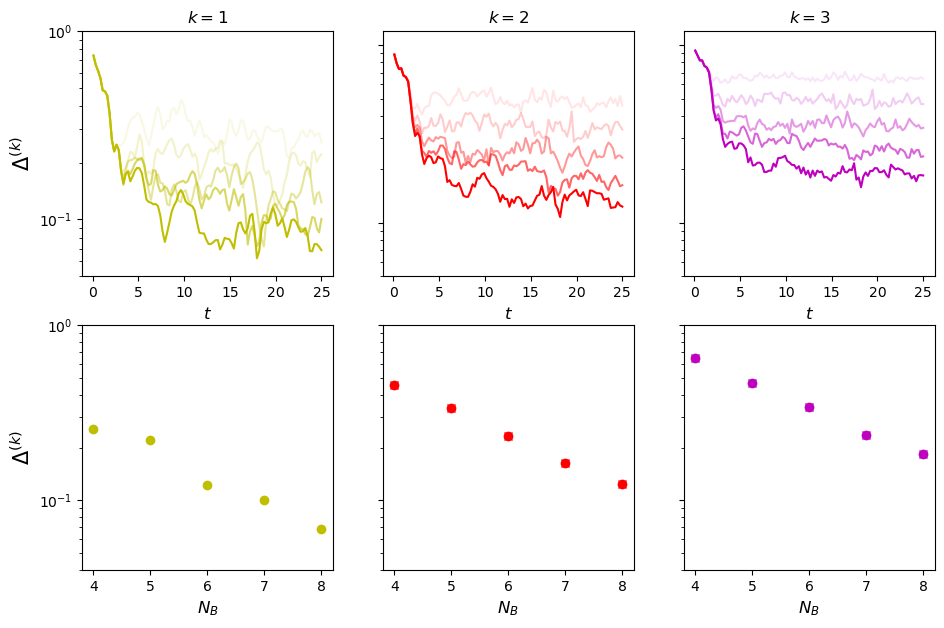

In [4]:
# We're storing data: times and trace distances from quenched state moments to new ensemble moments
times = np.linspace(0.1,25,100)
# Shape: 5 values of N_B, 3 moments, for each time
Dist = np.empty((5,3,np.size(times)))

# Fixed variables
N_A = 2
h_x = 0.8090
h_y = 0.9045
J = 1
q = 0
d = 2 ** N_A

N_Bs = [4,5,6,7,8]

for i, N_B in enumerate(N_Bs):
    # define Hamiltonian, get initial state
    H = QIMF(N_A + N_B, h_x, h_y, J)
    Psi0 = np.zeros(2 ** (N_A + N_B))
    Psi0[0] = 1

    # Get relevant probability r and moments of new ensemble
    r = 1 - (1-q) ** N_B
    rho_1 = rho_new_1(rho_1_Haar(d), r)
    rho_2 = rho_new_2(rho_1_Haar(d), rho_2_Haar(d), r)
    rho_3 = rho_new_3(rho_1_Haar(d), rho_2_Haar(d), rho_3_Haar(d), r)

    for j, t in enumerate(times):
        # For each time, get quenched state and the mixed ensemble of faulty measurement outcomes
        U = expm(-t * 1j * H)
        Psi = U @ Psi0
        PrEns = Get_PrEns(Psi, N_A, N_B)
        MixEns = Get_MixEns(PrEns, N_A, N_B, q)
        
        # Then get the moments and the trace distances
        rho_1_sim = rho_MixEns(MixEns, 1)
        dist_1 = np.linalg.norm(rho_1 - rho_1_sim, 'nuc') / 2
        Dist[i,0,j] = dist_1

        rho_2_sim = rho_MixEns(MixEns, 2)
        dist_2 = np.linalg.norm(rho_2 - rho_2_sim, 'nuc') / 2
        Dist[i,1,j] = dist_2

        rho_3_sim = rho_MixEns(MixEns, 3)
        dist_3 = np.linalg.norm(rho_3 - rho_3_sim, 'nuc') / 2
        Dist[i,2,j] = dist_3

# We are also calculating trace distances from the Haar moments at late times for comparison
Haar_dist = np.empty((5, 3))
t = times[-1]
for i, N_B in enumerate(N_Bs):
    H = QIMF(N_A + N_B, h_x, h_y, J)
    Psi0 = np.zeros(2 ** (N_A + N_B))
    Psi0[0] = 1
    
    U = expm(-t * 1j * H)
    Psi = U @ Psi0
    PrEns = Get_PrEns(Psi, N_A, N_B)
    MixEns = Get_MixEns(PrEns, N_A, N_B, q)

    rho_1 = rho_1_Haar(d)
    rho_2 = rho_2_Haar(d)
    rho_3 = rho_3_Haar(d)

    rho_1_sim = rho_MixEns(MixEns, 1)
    Haar_dist[i,0] = np.linalg.norm(rho_1 - rho_1_sim, 'nuc') / 2

    rho_2_sim = rho_MixEns(MixEns, 2)
    Haar_dist[i,1] = np.linalg.norm(rho_2 - rho_2_sim, 'nuc') / 2

    rho_3_sim = rho_MixEns(MixEns, 3)
    Haar_dist[i,2] = np.linalg.norm(rho_3 - rho_3_sim, 'nuc') / 2

# plot
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(11,7))

# distances for different N_B with time on a log scale
# first moment
axes[0,0].plot(times, Dist[0,0], color='y', alpha=0.1)
axes[0,0].plot(times, Dist[1,0], color='y', alpha=0.2)
axes[0,0].plot(times, Dist[2,0], color='y', alpha=0.4)
axes[0,0].plot(times, Dist[3,0], color='y', alpha=0.6)
axes[0,0].plot(times, Dist[4,0], color='y', alpha=1)
axes[0,0].set_yscale('log')
axes[0,0].set_ylim(0.05,1)
axes[0,0].set_ylabel('$\Delta^{(k)}$',size=15)
axes[0,0].set_xlabel('$t$',size=12)
axes[0,0].set_title('$k = 1$')

# second moment
axes[0,1].plot(times, Dist[0,1], color='r', alpha=0.1)
axes[0,1].plot(times, Dist[1,1], color='r', alpha=0.2)
axes[0,1].plot(times, Dist[2,1], color='r', alpha=0.4)
axes[0,1].plot(times, Dist[3,1], color='r', alpha=0.6)
axes[0,1].plot(times, Dist[4,1], color='r', alpha=1)
axes[0,1].set_yscale('log')
axes[0,1].set_ylim(0.05,1.2)
axes[0,1].set_yticklabels('')
axes[0,1].set_xlabel('$t$',size=12)
axes[0,1].set_title('$k=2$')

# third moment
axes[0,2].plot(times, Dist[0,2], color='m', alpha=0.1)
axes[0,2].plot(times, Dist[1,2], color='m', alpha=0.2)
axes[0,2].plot(times, Dist[2,2], color='m', alpha=0.4)
axes[0,2].plot(times, Dist[3,2], color='m', alpha=0.6)
axes[0,2].plot(times, Dist[4,2], color='m', alpha=1)
axes[0,2].set_yscale('log')
axes[0,2].set_ylim(0.05,1.2)
axes[0,2].set_yticklabels('')
axes[0,2].set_xlabel('$t$',size=12)
axes[0,2].set_title('$k=3$')

# Late time scaling of distance with N_B, as well as comparison with Haar ensemble, again for three moments
axes[1,0].plot(N_Bs, Dist[:,0,-1], 'yo')
axes[1,0].set_yscale('log')
axes[1,0].set_ylim(0.04,1)
axes[1,0].set_ylabel('$\Delta^{(k)}$',size=15)
axes[1,0].set_xlabel('$N_B$',size=12)

axes[1,1].plot(N_Bs, Dist[:,1,-1], 'ro')
axes[1,1].plot(N_Bs, Haar_dist[:,1], 'rx')
axes[1,1].set_yscale('log')
axes[1,1].set_ylim(0.04,1)
axes[1,1].set_yticklabels('')
axes[1,1].set_xlabel('$N_B$',size=12)

axes[1,2].plot(N_Bs, Dist[:,2,-1], 'mo')
axes[1,2].plot(N_Bs, Haar_dist[:,2], 'mx')
axes[1,2].set_yscale('log')
axes[1,2].set_ylim(0.04,1)
axes[1,2].set_yticklabels('')
axes[1,2].set_xlabel('$N_B$',size=12)

### $q = 0.01$

Text(0.5, 0, '$N_B$')

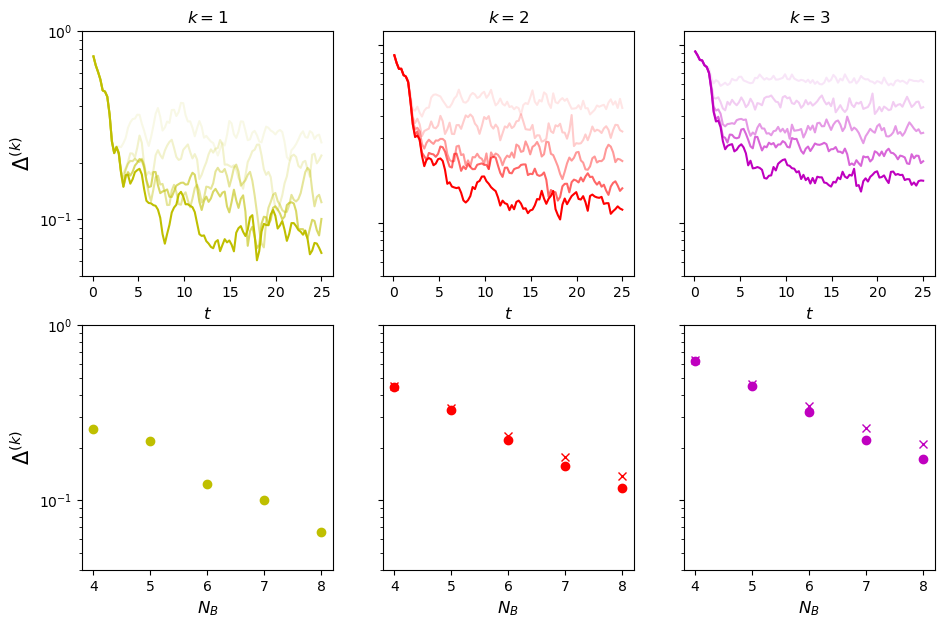

In [5]:
times = np.linspace(0.1,25,100)
Dist = np.empty((5,3,np.size(times)))

N_A = 2
h_x = 0.8090
h_y = 0.9045
J = 1
q = 0.01

d = 2 ** N_A

N_Bs = [4,5,6,7,8]

for i, N_B in enumerate(N_Bs):

    H = QIMF(N_A + N_B, h_x, h_y, J)
    Psi0 = np.zeros(2 ** (N_A + N_B))
    Psi0[0] = 1

    r = 1 - (1-q) ** N_B
    rho_1 = rho_new_1(rho_1_Haar(d), r)
    rho_2 = rho_new_2(rho_1_Haar(d), rho_2_Haar(d), r)
    rho_3 = rho_new_3(rho_1_Haar(d), rho_2_Haar(d), rho_3_Haar(d), r)

    for j, t in enumerate(times):
        U = expm(-t * 1j * H)
        Psi = U @ Psi0
        PrEns = Get_PrEns(Psi, N_A, N_B)
        MixEns = Get_MixEns(PrEns, N_A, N_B, q)
        
        rho_1_sim = rho_MixEns(MixEns, 1)
        dist_1 = np.linalg.norm(rho_1 - rho_1_sim, 'nuc') / 2
        Dist[i,0,j] = dist_1

        rho_2_sim = rho_MixEns(MixEns, 2)
        dist_2 = np.linalg.norm(rho_2 - rho_2_sim, 'nuc') / 2
        Dist[i,1,j] = dist_2

        rho_3_sim = rho_MixEns(MixEns, 3)
        dist_3 = np.linalg.norm(rho_3 - rho_3_sim, 'nuc') / 2
        Dist[i,2,j] = dist_3

Haar_dist = np.empty((5, 3))
t = times[-1]
for i, N_B in enumerate(N_Bs):
    H = QIMF(N_A + N_B, h_x, h_y, J)
    Psi0 = np.zeros(2 ** (N_A + N_B))
    Psi0[0] = 1
    
    U = expm(-t * 1j * H)
    Psi = U @ Psi0
    PrEns = Get_PrEns(Psi, N_A, N_B)
    MixEns = Get_MixEns(PrEns, N_A, N_B, q)

    rho_1 = rho_1_Haar(d)
    rho_2 = rho_2_Haar(d)
    rho_3 = rho_3_Haar(d)

    rho_1_sim = rho_MixEns(MixEns, 1)
    Haar_dist[i,0] = np.linalg.norm(rho_1 - rho_1_sim, 'nuc') / 2

    rho_2_sim = rho_MixEns(MixEns, 2)
    Haar_dist[i,1] = np.linalg.norm(rho_2 - rho_2_sim, 'nuc') / 2

    rho_3_sim = rho_MixEns(MixEns, 3)
    Haar_dist[i,2] = np.linalg.norm(rho_3 - rho_3_sim, 'nuc') / 2

fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(11,7))

axes[0,0].plot(times, Dist[0,0], color='y', alpha=0.1)
axes[0,0].plot(times, Dist[1,0], color='y', alpha=0.2)
axes[0,0].plot(times, Dist[2,0], color='y', alpha=0.4)
axes[0,0].plot(times, Dist[3,0], color='y', alpha=0.6)
axes[0,0].plot(times, Dist[4,0], color='y', alpha=1)
axes[0,0].set_yscale('log')
axes[0,0].set_ylim(0.05,1)
axes[0,0].set_ylabel('$\Delta^{(k)}$',size=15)
axes[0,0].set_xlabel('$t$',size=12)
axes[0,0].set_title('$k = 1$')

axes[0,1].plot(times, Dist[0,1], color='r', alpha=0.1)
axes[0,1].plot(times, Dist[1,1], color='r', alpha=0.2)
axes[0,1].plot(times, Dist[2,1], color='r', alpha=0.4)
axes[0,1].plot(times, Dist[3,1], color='r', alpha=0.6)
axes[0,1].plot(times, Dist[4,1], color='r', alpha=1)
axes[0,1].set_yscale('log')
axes[0,1].set_ylim(0.05,1.2)
axes[0,1].set_yticklabels('')
axes[0,1].set_xlabel('$t$',size=12)
axes[0,1].set_title('$k=2$')

axes[0,2].plot(times, Dist[0,2], color='m', alpha=0.1)
axes[0,2].plot(times, Dist[1,2], color='m', alpha=0.2)
axes[0,2].plot(times, Dist[2,2], color='m', alpha=0.4)
axes[0,2].plot(times, Dist[3,2], color='m', alpha=0.6)
axes[0,2].plot(times, Dist[4,2], color='m', alpha=1)
axes[0,2].set_yscale('log')
axes[0,2].set_ylim(0.05,1.2)
axes[0,2].set_yticklabels('')
axes[0,2].set_xlabel('$t$',size=12)
axes[0,2].set_title('$k=3$')

axes[1,0].plot(N_Bs, Dist[:,0,-1], 'yo')
axes[1,0].set_yscale('log')
axes[1,0].set_ylim(0.04,1)
axes[1,0].set_ylabel('$\Delta^{(k)}$',size=15)
axes[1,0].set_xlabel('$N_B$',size=12)

axes[1,1].plot(N_Bs, Dist[:,1,-1], 'ro')
axes[1,1].plot(N_Bs, Haar_dist[:,1], 'rx')
axes[1,1].set_yscale('log')
axes[1,1].set_ylim(0.04,1)
axes[1,1].set_yticklabels('')
axes[1,1].set_xlabel('$N_B$',size=12)

axes[1,2].plot(N_Bs, Dist[:,2,-1], 'mo')
axes[1,2].plot(N_Bs, Haar_dist[:,2], 'mx')
axes[1,2].set_yscale('log')
axes[1,2].set_ylim(0.04,1)
axes[1,2].set_yticklabels('')
axes[1,2].set_xlabel('$N_B$',size=12)

### $q=0.1$

Text(0.5, 0, '$N_B$')

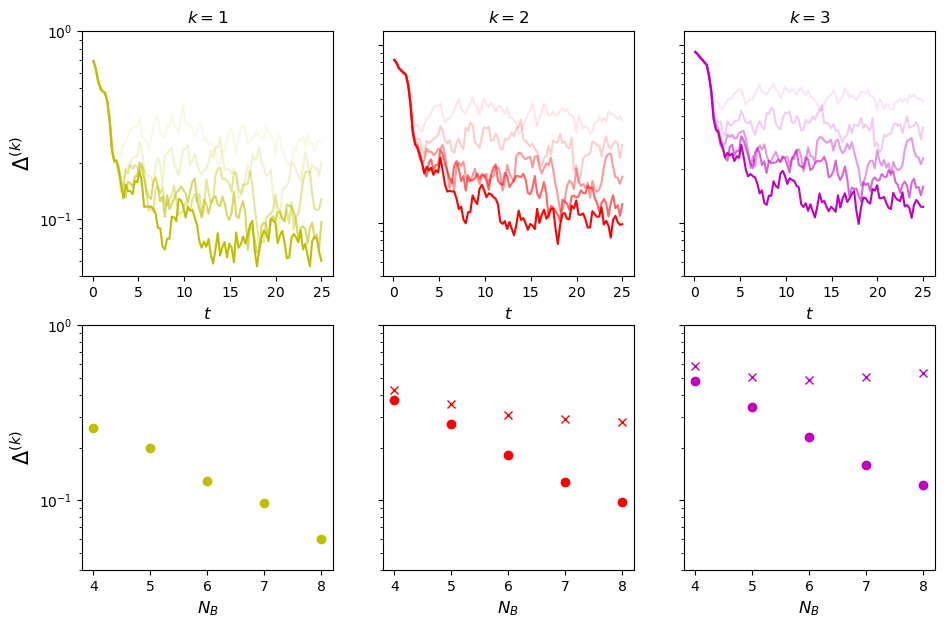

In [6]:
times = np.linspace(0.1,25,100)
Dist = np.empty((5,3,np.size(times)))

N_A = 2
h_x = 0.8090
h_y = 0.9045
J = 1
q = 0.1

d = 2 ** N_A

N_Bs = [4,5,6,7,8]

for i, N_B in enumerate(N_Bs):

    H = QIMF(N_A + N_B, h_x, h_y, J)
    Psi0 = np.zeros(2 ** (N_A + N_B))
    Psi0[0] = 1

    r = 1 - (1-q) ** N_B
    rho_1 = rho_new_1(rho_1_Haar(d), r)
    rho_2 = rho_new_2(rho_1_Haar(d), rho_2_Haar(d), r)
    rho_3 = rho_new_3(rho_1_Haar(d), rho_2_Haar(d), rho_3_Haar(d), r)

    for j, t in enumerate(times):
        U = expm(-t * 1j * H)
        Psi = U @ Psi0
        PrEns = Get_PrEns(Psi, N_A, N_B)
        MixEns = Get_MixEns(PrEns, N_A, N_B, q)
        
        rho_1_sim = rho_MixEns(MixEns, 1)
        dist_1 = np.linalg.norm(rho_1 - rho_1_sim, 'nuc') / 2
        Dist[i,0,j] = dist_1

        rho_2_sim = rho_MixEns(MixEns, 2)
        dist_2 = np.linalg.norm(rho_2 - rho_2_sim, 'nuc') / 2
        Dist[i,1,j] = dist_2

        rho_3_sim = rho_MixEns(MixEns, 3)
        dist_3 = np.linalg.norm(rho_3 - rho_3_sim, 'nuc') / 2
        Dist[i,2,j] = dist_3

Haar_dist = np.empty((5, 3))
t = times[-1]
for i, N_B in enumerate(N_Bs):
    H = QIMF(N_A + N_B, h_x, h_y, J)
    Psi0 = np.zeros(2 ** (N_A + N_B))
    Psi0[0] = 1
    
    U = expm(-t * 1j * H)
    Psi = U @ Psi0
    PrEns = Get_PrEns(Psi, N_A, N_B)
    MixEns = Get_MixEns(PrEns, N_A, N_B, q)

    rho_1 = rho_1_Haar(d)
    rho_2 = rho_2_Haar(d)
    rho_3 = rho_3_Haar(d)

    rho_1_sim = rho_MixEns(MixEns, 1)
    Haar_dist[i,0] = np.linalg.norm(rho_1 - rho_1_sim, 'nuc') / 2

    rho_2_sim = rho_MixEns(MixEns, 2)
    Haar_dist[i,1] = np.linalg.norm(rho_2 - rho_2_sim, 'nuc') / 2

    rho_3_sim = rho_MixEns(MixEns, 3)
    Haar_dist[i,2] = np.linalg.norm(rho_3 - rho_3_sim, 'nuc') / 2

fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(11,7))

axes[0,0].plot(times, Dist[0,0], color='y', alpha=0.1)
axes[0,0].plot(times, Dist[1,0], color='y', alpha=0.2)
axes[0,0].plot(times, Dist[2,0], color='y', alpha=0.4)
axes[0,0].plot(times, Dist[3,0], color='y', alpha=0.6)
axes[0,0].plot(times, Dist[4,0], color='y', alpha=1)
axes[0,0].set_yscale('log')
axes[0,0].set_ylim(0.05,1)
axes[0,0].set_ylabel('$\Delta^{(k)}$',size=15)
axes[0,0].set_xlabel('$t$',size=12)
axes[0,0].set_title('$k = 1$')

axes[0,1].plot(times, Dist[0,1], color='r', alpha=0.1)
axes[0,1].plot(times, Dist[1,1], color='r', alpha=0.2)
axes[0,1].plot(times, Dist[2,1], color='r', alpha=0.4)
axes[0,1].plot(times, Dist[3,1], color='r', alpha=0.6)
axes[0,1].plot(times, Dist[4,1], color='r', alpha=1)
axes[0,1].set_yscale('log')
axes[0,1].set_ylim(0.05,1.2)
axes[0,1].set_yticklabels('')
axes[0,1].set_xlabel('$t$',size=12)
axes[0,1].set_title('$k=2$')

axes[0,2].plot(times, Dist[0,2], color='m', alpha=0.1)
axes[0,2].plot(times, Dist[1,2], color='m', alpha=0.2)
axes[0,2].plot(times, Dist[2,2], color='m', alpha=0.4)
axes[0,2].plot(times, Dist[3,2], color='m', alpha=0.6)
axes[0,2].plot(times, Dist[4,2], color='m', alpha=1)
axes[0,2].set_yscale('log')
axes[0,2].set_ylim(0.05,1.2)
axes[0,2].set_yticklabels('')
axes[0,2].set_xlabel('$t$',size=12)
axes[0,2].set_title('$k=3$')

axes[1,0].plot(N_Bs, Dist[:,0,-1], 'yo')
axes[1,0].set_yscale('log')
axes[1,0].set_ylim(0.04,1)
axes[1,0].set_ylabel('$\Delta^{(k)}$',size=15)
axes[1,0].set_xlabel('$N_B$',size=12)

axes[1,1].plot(N_Bs, Dist[:,1,-1], 'ro')
axes[1,1].plot(N_Bs, Haar_dist[:,1], 'rx')
axes[1,1].set_yscale('log')
axes[1,1].set_ylim(0.04,1)
axes[1,1].set_yticklabels('')
axes[1,1].set_xlabel('$N_B$',size=12)

axes[1,2].plot(N_Bs, Dist[:,2,-1], 'mo')
axes[1,2].plot(N_Bs, Haar_dist[:,2], 'mx')
axes[1,2].set_yscale('log')
axes[1,2].set_ylim(0.04,1)
axes[1,2].set_yticklabels('')
axes[1,2].set_xlabel('$N_B$',size=12)

### $q=0.3$

Text(0.5, 0, '$N_B$')

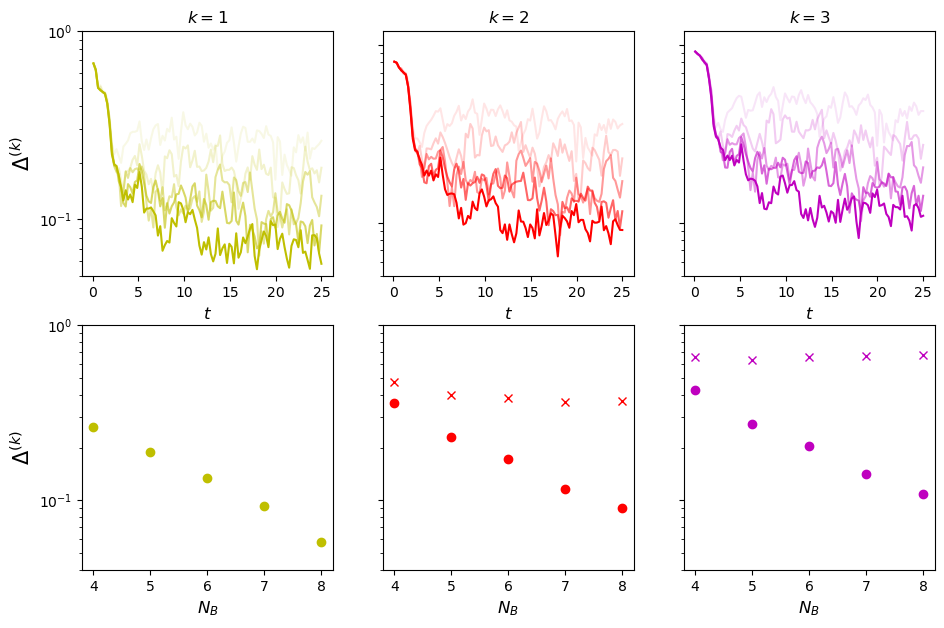

In [7]:
times = np.linspace(0.1,25,100)
Dist = np.empty((5,3,np.size(times)))

N_A = 2
h_x = 0.8090
h_y = 0.9045
J = 1
q = 0.3

d = 2 ** N_A

N_Bs = [4,5,6,7,8]

for i, N_B in enumerate(N_Bs):

    H = QIMF(N_A + N_B, h_x, h_y, J)
    Psi0 = np.zeros(2 ** (N_A + N_B))
    Psi0[0] = 1

    r = 1 - (1-q) ** N_B
    rho_1 = rho_new_1(rho_1_Haar(d), r)
    rho_2 = rho_new_2(rho_1_Haar(d), rho_2_Haar(d), r)
    rho_3 = rho_new_3(rho_1_Haar(d), rho_2_Haar(d), rho_3_Haar(d), r)

    for j, t in enumerate(times):
        U = expm(-t * 1j * H)
        Psi = U @ Psi0
        PrEns = Get_PrEns(Psi, N_A, N_B)
        MixEns = Get_MixEns(PrEns, N_A, N_B, q)
        
        rho_1_sim = rho_MixEns(MixEns, 1)
        dist_1 = np.linalg.norm(rho_1 - rho_1_sim, 'nuc') / 2
        Dist[i,0,j] = dist_1

        rho_2_sim = rho_MixEns(MixEns, 2)
        dist_2 = np.linalg.norm(rho_2 - rho_2_sim, 'nuc') / 2
        Dist[i,1,j] = dist_2

        rho_3_sim = rho_MixEns(MixEns, 3)
        dist_3 = np.linalg.norm(rho_3 - rho_3_sim, 'nuc') / 2
        Dist[i,2,j] = dist_3

Haar_dist = np.empty((5, 3))
t = times[-1]
for i, N_B in enumerate(N_Bs):
    H = QIMF(N_A + N_B, h_x, h_y, J)
    Psi0 = np.zeros(2 ** (N_A + N_B))
    Psi0[0] = 1
    
    U = expm(-t * 1j * H)
    Psi = U @ Psi0
    PrEns = Get_PrEns(Psi, N_A, N_B)
    MixEns = Get_MixEns(PrEns, N_A, N_B, q)

    rho_1 = rho_1_Haar(d)
    rho_2 = rho_2_Haar(d)
    rho_3 = rho_3_Haar(d)

    rho_1_sim = rho_MixEns(MixEns, 1)
    Haar_dist[i,0] = np.linalg.norm(rho_1 - rho_1_sim, 'nuc') / 2

    rho_2_sim = rho_MixEns(MixEns, 2)
    Haar_dist[i,1] = np.linalg.norm(rho_2 - rho_2_sim, 'nuc') / 2

    rho_3_sim = rho_MixEns(MixEns, 3)
    Haar_dist[i,2] = np.linalg.norm(rho_3 - rho_3_sim, 'nuc') / 2

fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(11,7))

axes[0,0].plot(times, Dist[0,0], color='y', alpha=0.1)
axes[0,0].plot(times, Dist[1,0], color='y', alpha=0.2)
axes[0,0].plot(times, Dist[2,0], color='y', alpha=0.4)
axes[0,0].plot(times, Dist[3,0], color='y', alpha=0.6)
axes[0,0].plot(times, Dist[4,0], color='y', alpha=1)
axes[0,0].set_yscale('log')
axes[0,0].set_ylim(0.05,1)
axes[0,0].set_ylabel('$\Delta^{(k)}$',size=15)
axes[0,0].set_xlabel('$t$',size=12)
axes[0,0].set_title('$k = 1$')

axes[0,1].plot(times, Dist[0,1], color='r', alpha=0.1)
axes[0,1].plot(times, Dist[1,1], color='r', alpha=0.2)
axes[0,1].plot(times, Dist[2,1], color='r', alpha=0.4)
axes[0,1].plot(times, Dist[3,1], color='r', alpha=0.6)
axes[0,1].plot(times, Dist[4,1], color='r', alpha=1)
axes[0,1].set_yscale('log')
axes[0,1].set_ylim(0.05,1.2)
axes[0,1].set_yticklabels('')
axes[0,1].set_xlabel('$t$',size=12)
axes[0,1].set_title('$k=2$')

axes[0,2].plot(times, Dist[0,2], color='m', alpha=0.1)
axes[0,2].plot(times, Dist[1,2], color='m', alpha=0.2)
axes[0,2].plot(times, Dist[2,2], color='m', alpha=0.4)
axes[0,2].plot(times, Dist[3,2], color='m', alpha=0.6)
axes[0,2].plot(times, Dist[4,2], color='m', alpha=1)
axes[0,2].set_yscale('log')
axes[0,2].set_ylim(0.05,1.2)
axes[0,2].set_yticklabels('')
axes[0,2].set_xlabel('$t$',size=12)
axes[0,2].set_title('$k=3$')

axes[1,0].plot(N_Bs, Dist[:,0,-1], 'yo')
axes[1,0].set_yscale('log')
axes[1,0].set_ylim(0.04,1)
axes[1,0].set_ylabel('$\Delta^{(k)}$',size=15)
axes[1,0].set_xlabel('$N_B$',size=12)

axes[1,1].plot(N_Bs, Dist[:,1,-1], 'ro')
axes[1,1].plot(N_Bs, Haar_dist[:,1], 'rx')
axes[1,1].set_yscale('log')
axes[1,1].set_ylim(0.04,1)
axes[1,1].set_yticklabels('')
axes[1,1].set_xlabel('$N_B$',size=12)

axes[1,2].plot(N_Bs, Dist[:,2,-1], 'mo')
axes[1,2].plot(N_Bs, Haar_dist[:,2], 'mx')
axes[1,2].set_yscale('log')
axes[1,2].set_ylim(0.04,1)
axes[1,2].set_yticklabels('')
axes[1,2].set_xlabel('$N_B$',size=12)

## Experiment 2: integrable system

As $N_B$ increases, two things happen: the moments of the pure ensemble tend to the Haar moments (as Cotler et al showed), and the error probability $r$ increases, tending to unity in the limit of $N_B \to \infty$. To check whether or not the 'new ensemble' actually describes the faulty measurements well I perform some additional tests. 

First, change the Hamiltonian by turning off one of the fields to get an integrable system (transverse field Ising model). Now the pure ensemble will no longer form a $k$-design, but $r$ will still increase with $N_B$, so if the latter effect dominates we should still see a kind of convergence. The result below is that we do not (which really means that the integrable system fails to form even a 1-design).

### $h_x = 0$, $q = 0.3$ (s.t. $r$ fairly large)

Code otherwise identical to above.

Text(0.5, 0, '$N_B$')

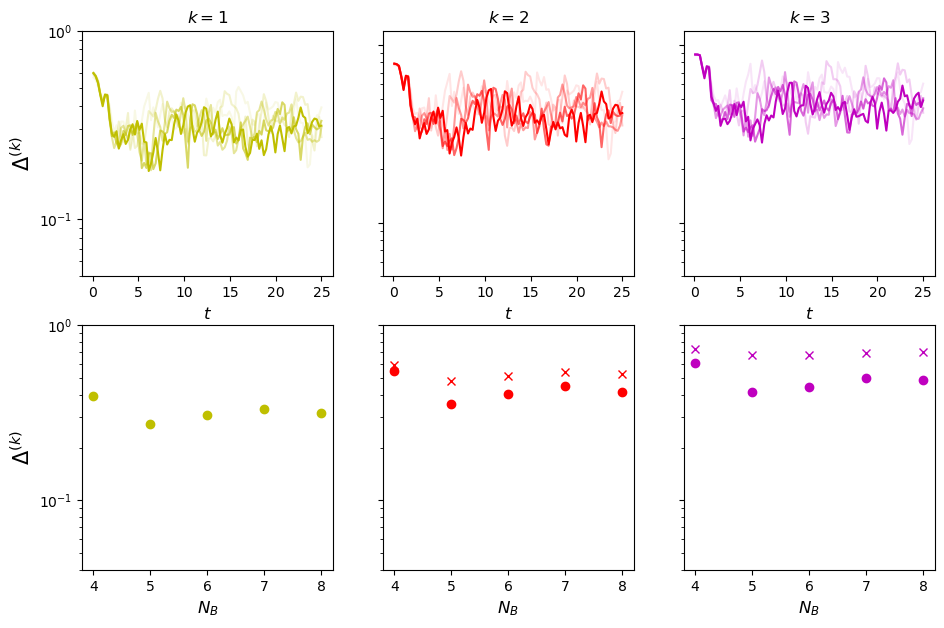

In [8]:
times = np.linspace(0.1,25,100)
Dist = np.empty((5,3,np.size(times)))

N_A = 2
h_x = 0
h_y = 0.9045
J = 1
q = 0.3

d = 2 ** N_A

N_Bs = [4,5,6,7,8]

for i, N_B in enumerate(N_Bs):

    H = QIMF(N_A + N_B, h_x, h_y, J)
    Psi0 = np.zeros(2 ** (N_A + N_B))
    Psi0[0] = 1

    r = 1 - (1-q) ** N_B
    rho_1 = rho_new_1(rho_1_Haar(d), r)
    rho_2 = rho_new_2(rho_1_Haar(d), rho_2_Haar(d), r)
    rho_3 = rho_new_3(rho_1_Haar(d), rho_2_Haar(d), rho_3_Haar(d), r)

    for j, t in enumerate(times):
        U = expm(-t * 1j * H)
        Psi = U @ Psi0
        PrEns = Get_PrEns(Psi, N_A, N_B)
        MixEns = Get_MixEns(PrEns, N_A, N_B, q)
        
        rho_1_sim = rho_MixEns(MixEns, 1)
        dist_1 = np.linalg.norm(rho_1 - rho_1_sim, 'nuc') / 2
        Dist[i,0,j] = dist_1

        rho_2_sim = rho_MixEns(MixEns, 2)
        dist_2 = np.linalg.norm(rho_2 - rho_2_sim, 'nuc') / 2
        Dist[i,1,j] = dist_2

        rho_3_sim = rho_MixEns(MixEns, 3)
        dist_3 = np.linalg.norm(rho_3 - rho_3_sim, 'nuc') / 2
        Dist[i,2,j] = dist_3

Haar_dist = np.empty((5, 3))
t = times[-1]
for i, N_B in enumerate(N_Bs):
    H = QIMF(N_A + N_B, h_x, h_y, J)
    Psi0 = np.zeros(2 ** (N_A + N_B))
    Psi0[0] = 1
    
    U = expm(-t * 1j * H)
    Psi = U @ Psi0
    PrEns = Get_PrEns(Psi, N_A, N_B)
    MixEns = Get_MixEns(PrEns, N_A, N_B, q)

    rho_1 = rho_1_Haar(d)
    rho_2 = rho_2_Haar(d)
    rho_3 = rho_3_Haar(d)

    rho_1_sim = rho_MixEns(MixEns, 1)
    Haar_dist[i,0] = np.linalg.norm(rho_1 - rho_1_sim, 'nuc') / 2

    rho_2_sim = rho_MixEns(MixEns, 2)
    Haar_dist[i,1] = np.linalg.norm(rho_2 - rho_2_sim, 'nuc') / 2

    rho_3_sim = rho_MixEns(MixEns, 3)
    Haar_dist[i,2] = np.linalg.norm(rho_3 - rho_3_sim, 'nuc') / 2

fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(11,7))

axes[0,0].plot(times, Dist[0,0], color='y', alpha=0.1)
axes[0,0].plot(times, Dist[1,0], color='y', alpha=0.2)
axes[0,0].plot(times, Dist[2,0], color='y', alpha=0.4)
axes[0,0].plot(times, Dist[3,0], color='y', alpha=0.6)
axes[0,0].plot(times, Dist[4,0], color='y', alpha=1)
axes[0,0].set_yscale('log')
axes[0,0].set_ylim(0.05,1)
axes[0,0].set_ylabel('$\Delta^{(k)}$',size=15)
axes[0,0].set_xlabel('$t$',size=12)
axes[0,0].set_title('$k = 1$')

axes[0,1].plot(times, Dist[0,1], color='r', alpha=0.1)
axes[0,1].plot(times, Dist[1,1], color='r', alpha=0.2)
axes[0,1].plot(times, Dist[2,1], color='r', alpha=0.4)
axes[0,1].plot(times, Dist[3,1], color='r', alpha=0.6)
axes[0,1].plot(times, Dist[4,1], color='r', alpha=1)
axes[0,1].set_yscale('log')
axes[0,1].set_ylim(0.05,1.2)
axes[0,1].set_yticklabels('')
axes[0,1].set_xlabel('$t$',size=12)
axes[0,1].set_title('$k=2$')

axes[0,2].plot(times, Dist[0,2], color='m', alpha=0.1)
axes[0,2].plot(times, Dist[1,2], color='m', alpha=0.2)
axes[0,2].plot(times, Dist[2,2], color='m', alpha=0.4)
axes[0,2].plot(times, Dist[3,2], color='m', alpha=0.6)
axes[0,2].plot(times, Dist[4,2], color='m', alpha=1)
axes[0,2].set_yscale('log')
axes[0,2].set_ylim(0.05,1.2)
axes[0,2].set_yticklabels('')
axes[0,2].set_xlabel('$t$',size=12)
axes[0,2].set_title('$k=3$')

axes[1,0].plot(N_Bs, Dist[:,0,-1], 'yo')
axes[1,0].set_yscale('log')
axes[1,0].set_ylim(0.04,1)
axes[1,0].set_ylabel('$\Delta^{(k)}$',size=15)
axes[1,0].set_xlabel('$N_B$',size=12)

axes[1,1].plot(N_Bs, Dist[:,1,-1], 'ro')
axes[1,1].plot(N_Bs, Haar_dist[:,1], 'rx')
axes[1,1].set_yscale('log')
axes[1,1].set_ylim(0.04,1)
axes[1,1].set_yticklabels('')
axes[1,1].set_xlabel('$N_B$',size=12)

axes[1,2].plot(N_Bs, Dist[:,2,-1], 'mo')
axes[1,2].plot(N_Bs, Haar_dist[:,2], 'mx')
axes[1,2].set_yscale('log')
axes[1,2].set_ylim(0.04,1)
axes[1,2].set_yticklabels('')
axes[1,2].set_xlabel('$N_B$',size=12)

## Experiment 3: $r$ constant, $q$ variable

As $N_B$ increases, two things happen: the moments of the pure ensemble tend to the Haar moments (as Cotler et al showed), and the error probability $r$ increases, tending to unity in the limit of $N_B \to \infty$. To check whether or not the 'new ensemble' actually describes the faulty measurements well I perform some additional tests. 

Here, rather than having $q$ fixed such that $r = 1 - (1-q)^{N_B}$ increases with $N_B$, we fix $r$ and have $q = 1 - (1-r)^{1 / N_B}$ decrease with $N_B$. With this change we keep seeing the quick decrease of trace distance under chaotic time evolution, and the approximately exponential scaling with $N_B$ of the late-time average. This strongly suggests that the 'new ensemble' describes the ensembles of mixed states well in the limit of large $N_B$.

### $r = 0.05$
Apart from the change in defining $r$ and $q$ code is identical to above.

In [ ]:
times = np.linspace(0.1,25,100)
Dist = np.empty((5,3,np.size(times)))

N_A = 2
h_x = 0.8090
h_y = 0.9045
J = 1
r = 0.05

d = 2 ** N_A

N_Bs = [4,5,6,7,8]

for i, N_B in enumerate(N_Bs):

    H = QIMF(N_A + N_B, h_x, h_y, J)
    Psi0 = np.zeros(2 ** (N_A + N_B))
    Psi0[0] = 1

    q = 1 - (1-r) ** (1 / N_B)
    rho_1 = rho_new_1(rho_1_Haar(d), r)
    rho_2 = rho_new_2(rho_1_Haar(d), rho_2_Haar(d), r)
    rho_3 = rho_new_3(rho_1_Haar(d), rho_2_Haar(d), rho_3_Haar(d), r)

    for j, t in enumerate(times):
        U = expm(-t * 1j * H)
        Psi = U @ Psi0
        PrEns = Get_PrEns(Psi, N_A, N_B)
        MixEns = Get_MixEns(PrEns, N_A, N_B, q)
        
        rho_1_sim = rho_MixEns(MixEns, 1)
        dist_1 = np.linalg.norm(rho_1 - rho_1_sim, 'nuc') / 2
        Dist[i,0,j] = dist_1

        rho_2_sim = rho_MixEns(MixEns, 2)
        dist_2 = np.linalg.norm(rho_2 - rho_2_sim, 'nuc') / 2
        Dist[i,1,j] = dist_2

        rho_3_sim = rho_MixEns(MixEns, 3)
        dist_3 = np.linalg.norm(rho_3 - rho_3_sim, 'nuc') / 2
        Dist[i,2,j] = dist_3

Haar_dist = np.empty((5, 3))
t = times[-1]
for i, N_B in enumerate(N_Bs):
    H = QIMF(N_A + N_B, h_x, h_y, J)
    Psi0 = np.zeros(2 ** (N_A + N_B))
    Psi0[0] = 1
    
    U = expm(-t * 1j * H)
    Psi = U @ Psi0
    PrEns = Get_PrEns(Psi, N_A, N_B)
    MixEns = Get_MixEns(PrEns, N_A, N_B, q)

    rho_1 = rho_1_Haar(d)
    rho_2 = rho_2_Haar(d)
    rho_3 = rho_3_Haar(d)

    rho_1_sim = rho_MixEns(MixEns, 1)
    Haar_dist[i,0] = np.linalg.norm(rho_1 - rho_1_sim, 'nuc') / 2

    rho_2_sim = rho_MixEns(MixEns, 2)
    Haar_dist[i,1] = np.linalg.norm(rho_2 - rho_2_sim, 'nuc') / 2

    rho_3_sim = rho_MixEns(MixEns, 3)
    Haar_dist[i,2] = np.linalg.norm(rho_3 - rho_3_sim, 'nuc') / 2

fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(11,7))

axes[0,0].plot(times, Dist[0,0], color='y', alpha=0.1)
axes[0,0].plot(times, Dist[1,0], color='y', alpha=0.2)
axes[0,0].plot(times, Dist[2,0], color='y', alpha=0.4)
axes[0,0].plot(times, Dist[3,0], color='y', alpha=0.6)
axes[0,0].plot(times, Dist[4,0], color='y', alpha=1)
axes[0,0].set_yscale('log')
axes[0,0].set_ylim(0.05,1)
axes[0,0].set_ylabel('$\Delta^{(k)}$',size=15)
axes[0,0].set_xlabel('$t$',size=12)
axes[0,0].set_title('$k = 1$')

axes[0,1].plot(times, Dist[0,1], color='r', alpha=0.1)
axes[0,1].plot(times, Dist[1,1], color='r', alpha=0.2)
axes[0,1].plot(times, Dist[2,1], color='r', alpha=0.4)
axes[0,1].plot(times, Dist[3,1], color='r', alpha=0.6)
axes[0,1].plot(times, Dist[4,1], color='r', alpha=1)
axes[0,1].set_yscale('log')
axes[0,1].set_ylim(0.05,1.2)
axes[0,1].set_yticklabels('')
axes[0,1].set_xlabel('$t$',size=12)
axes[0,1].set_title('$k=2$')

axes[0,2].plot(times, Dist[0,2], color='m', alpha=0.1)
axes[0,2].plot(times, Dist[1,2], color='m', alpha=0.2)
axes[0,2].plot(times, Dist[2,2], color='m', alpha=0.4)
axes[0,2].plot(times, Dist[3,2], color='m', alpha=0.6)
axes[0,2].plot(times, Dist[4,2], color='m', alpha=1)
axes[0,2].set_yscale('log')
axes[0,2].set_ylim(0.05,1.2)
axes[0,2].set_yticklabels('')
axes[0,2].set_xlabel('$t$',size=12)
axes[0,2].set_title('$k=3$')

axes[1,0].plot(N_Bs, Dist[:,0,-1], 'yo')
axes[1,0].set_yscale('log')
axes[1,0].set_ylim(0.04,1)
axes[1,0].set_ylabel('$\Delta^{(k)}$',size=15)
axes[1,0].set_xlabel('$N_B$',size=12)

axes[1,1].plot(N_Bs, Dist[:,1,-1], 'ro')
axes[1,1].plot(N_Bs, Haar_dist[:,1], 'rx')
axes[1,1].set_yscale('log')
axes[1,1].set_ylim(0.04,1)
axes[1,1].set_yticklabels('')
axes[1,1].set_xlabel('$N_B$',size=12)

axes[1,2].plot(N_Bs, Dist[:,2,-1], 'mo')
axes[1,2].plot(N_Bs, Haar_dist[:,2], 'mx')
axes[1,2].set_yscale('log')
axes[1,2].set_ylim(0.04,1)
axes[1,2].set_yticklabels('')
axes[1,2].set_xlabel('$N_B$',size=12)

### $r = 0.1$

In [ ]:
times = np.linspace(0.1,25,100)
Dist = np.empty((5,3,np.size(times)))

N_A = 2
h_x = 0.8090
h_y = 0.9045
J = 1
r = 0.1

d = 2 ** N_A

N_Bs = [4,5,6,7,8]

for i, N_B in enumerate(N_Bs):

    H = QIMF(N_A + N_B, h_x, h_y, J)
    Psi0 = np.zeros(2 ** (N_A + N_B))
    Psi0[0] = 1

    q = 1 - (1-r) ** (1 / N_B)
    rho_1 = rho_new_1(rho_1_Haar(d), r)
    rho_2 = rho_new_2(rho_1_Haar(d), rho_2_Haar(d), r)
    rho_3 = rho_new_3(rho_1_Haar(d), rho_2_Haar(d), rho_3_Haar(d), r)

    for j, t in enumerate(times):
        U = expm(-t * 1j * H)
        Psi = U @ Psi0
        PrEns = Get_PrEns(Psi, N_A, N_B)
        MixEns = Get_MixEns(PrEns, N_A, N_B, q)
        
        rho_1_sim = rho_MixEns(MixEns, 1)
        dist_1 = np.linalg.norm(rho_1 - rho_1_sim, 'nuc') / 2
        Dist[i,0,j] = dist_1

        rho_2_sim = rho_MixEns(MixEns, 2)
        dist_2 = np.linalg.norm(rho_2 - rho_2_sim, 'nuc') / 2
        Dist[i,1,j] = dist_2

        rho_3_sim = rho_MixEns(MixEns, 3)
        dist_3 = np.linalg.norm(rho_3 - rho_3_sim, 'nuc') / 2
        Dist[i,2,j] = dist_3

Haar_dist = np.empty((5, 3))
t = times[-1]
for i, N_B in enumerate(N_Bs):
    H = QIMF(N_A + N_B, h_x, h_y, J)
    Psi0 = np.zeros(2 ** (N_A + N_B))
    Psi0[0] = 1
    
    U = expm(-t * 1j * H)
    Psi = U @ Psi0
    PrEns = Get_PrEns(Psi, N_A, N_B)
    MixEns = Get_MixEns(PrEns, N_A, N_B, q)

    rho_1 = rho_1_Haar(d)
    rho_2 = rho_2_Haar(d)
    rho_3 = rho_3_Haar(d)

    rho_1_sim = rho_MixEns(MixEns, 1)
    Haar_dist[i,0] = np.linalg.norm(rho_1 - rho_1_sim, 'nuc') / 2

    rho_2_sim = rho_MixEns(MixEns, 2)
    Haar_dist[i,1] = np.linalg.norm(rho_2 - rho_2_sim, 'nuc') / 2

    rho_3_sim = rho_MixEns(MixEns, 3)
    Haar_dist[i,2] = np.linalg.norm(rho_3 - rho_3_sim, 'nuc') / 2

fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(11,7))

axes[0,0].plot(times, Dist[0,0], color='y', alpha=0.1)
axes[0,0].plot(times, Dist[1,0], color='y', alpha=0.2)
axes[0,0].plot(times, Dist[2,0], color='y', alpha=0.4)
axes[0,0].plot(times, Dist[3,0], color='y', alpha=0.6)
axes[0,0].plot(times, Dist[4,0], color='y', alpha=1)
axes[0,0].set_yscale('log')
axes[0,0].set_ylim(0.05,1)
axes[0,0].set_ylabel('$\Delta^{(k)}$',size=15)
axes[0,0].set_xlabel('$t$',size=12)
axes[0,0].set_title('$k = 1$')

axes[0,1].plot(times, Dist[0,1], color='r', alpha=0.1)
axes[0,1].plot(times, Dist[1,1], color='r', alpha=0.2)
axes[0,1].plot(times, Dist[2,1], color='r', alpha=0.4)
axes[0,1].plot(times, Dist[3,1], color='r', alpha=0.6)
axes[0,1].plot(times, Dist[4,1], color='r', alpha=1)
axes[0,1].set_yscale('log')
axes[0,1].set_ylim(0.05,1.2)
axes[0,1].set_yticklabels('')
axes[0,1].set_xlabel('$t$',size=12)
axes[0,1].set_title('$k=2$')

axes[0,2].plot(times, Dist[0,2], color='m', alpha=0.1)
axes[0,2].plot(times, Dist[1,2], color='m', alpha=0.2)
axes[0,2].plot(times, Dist[2,2], color='m', alpha=0.4)
axes[0,2].plot(times, Dist[3,2], color='m', alpha=0.6)
axes[0,2].plot(times, Dist[4,2], color='m', alpha=1)
axes[0,2].set_yscale('log')
axes[0,2].set_ylim(0.05,1.2)
axes[0,2].set_yticklabels('')
axes[0,2].set_xlabel('$t$',size=12)
axes[0,2].set_title('$k=3$')

axes[1,0].plot(N_Bs, Dist[:,0,-1], 'yo')
axes[1,0].set_yscale('log')
axes[1,0].set_ylim(0.04,1)
axes[1,0].set_ylabel('$\Delta^{(k)}$',size=15)
axes[1,0].set_xlabel('$N_B$',size=12)

axes[1,1].plot(N_Bs, Dist[:,1,-1], 'ro')
axes[1,1].plot(N_Bs, Haar_dist[:,1], 'rx')
axes[1,1].set_yscale('log')
axes[1,1].set_ylim(0.04,1)
axes[1,1].set_yticklabels('')
axes[1,1].set_xlabel('$N_B$',size=12)

axes[1,2].plot(N_Bs, Dist[:,2,-1], 'mo')
axes[1,2].plot(N_Bs, Haar_dist[:,2], 'mx')
axes[1,2].set_yscale('log')
axes[1,2].set_ylim(0.04,1)
axes[1,2].set_yticklabels('')
axes[1,2].set_xlabel('$N_B$',size=12)

### $r = 0.3$

In [ ]:
times = np.linspace(0.1,25,100)
Dist = np.empty((5,3,np.size(times)))

N_A = 2
h_x = 0.8090
h_y = 0.9045
J = 1
r = 0.3

d = 2 ** N_A

N_Bs = [4,5,6,7,8]

for i, N_B in enumerate(N_Bs):

    H = QIMF(N_A + N_B, h_x, h_y, J)
    Psi0 = np.zeros(2 ** (N_A + N_B))
    Psi0[0] = 1

    q = 1 - (1-r) ** (1 / N_B)
    rho_1 = rho_new_1(rho_1_Haar(d), r)
    rho_2 = rho_new_2(rho_1_Haar(d), rho_2_Haar(d), r)
    rho_3 = rho_new_3(rho_1_Haar(d), rho_2_Haar(d), rho_3_Haar(d), r)

    for j, t in enumerate(times):
        U = expm(-t * 1j * H)
        Psi = U @ Psi0
        PrEns = Get_PrEns(Psi, N_A, N_B)
        MixEns = Get_MixEns(PrEns, N_A, N_B, q)
        
        rho_1_sim = rho_MixEns(MixEns, 1)
        dist_1 = np.linalg.norm(rho_1 - rho_1_sim, 'nuc') / 2
        Dist[i,0,j] = dist_1

        rho_2_sim = rho_MixEns(MixEns, 2)
        dist_2 = np.linalg.norm(rho_2 - rho_2_sim, 'nuc') / 2
        Dist[i,1,j] = dist_2

        rho_3_sim = rho_MixEns(MixEns, 3)
        dist_3 = np.linalg.norm(rho_3 - rho_3_sim, 'nuc') / 2
        Dist[i,2,j] = dist_3

Haar_dist = np.empty((5, 3))
t = times[-1]
for i, N_B in enumerate(N_Bs):
    H = QIMF(N_A + N_B, h_x, h_y, J)
    Psi0 = np.zeros(2 ** (N_A + N_B))
    Psi0[0] = 1
    
    U = expm(-t * 1j * H)
    Psi = U @ Psi0
    PrEns = Get_PrEns(Psi, N_A, N_B)
    MixEns = Get_MixEns(PrEns, N_A, N_B, q)

    rho_1 = rho_1_Haar(d)
    rho_2 = rho_2_Haar(d)
    rho_3 = rho_3_Haar(d)

    rho_1_sim = rho_MixEns(MixEns, 1)
    Haar_dist[i,0] = np.linalg.norm(rho_1 - rho_1_sim, 'nuc') / 2

    rho_2_sim = rho_MixEns(MixEns, 2)
    Haar_dist[i,1] = np.linalg.norm(rho_2 - rho_2_sim, 'nuc') / 2

    rho_3_sim = rho_MixEns(MixEns, 3)
    Haar_dist[i,2] = np.linalg.norm(rho_3 - rho_3_sim, 'nuc') / 2

fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(11,7))

axes[0,0].plot(times, Dist[0,0], color='y', alpha=0.1)
axes[0,0].plot(times, Dist[1,0], color='y', alpha=0.2)
axes[0,0].plot(times, Dist[2,0], color='y', alpha=0.4)
axes[0,0].plot(times, Dist[3,0], color='y', alpha=0.6)
axes[0,0].plot(times, Dist[4,0], color='y', alpha=1)
axes[0,0].set_yscale('log')
axes[0,0].set_ylim(0.05,1)
axes[0,0].set_ylabel('$\Delta^{(k)}$',size=15)
axes[0,0].set_xlabel('$t$',size=12)
axes[0,0].set_title('$k = 1$')

axes[0,1].plot(times, Dist[0,1], color='r', alpha=0.1)
axes[0,1].plot(times, Dist[1,1], color='r', alpha=0.2)
axes[0,1].plot(times, Dist[2,1], color='r', alpha=0.4)
axes[0,1].plot(times, Dist[3,1], color='r', alpha=0.6)
axes[0,1].plot(times, Dist[4,1], color='r', alpha=1)
axes[0,1].set_yscale('log')
axes[0,1].set_ylim(0.05,1.2)
axes[0,1].set_yticklabels('')
axes[0,1].set_xlabel('$t$',size=12)
axes[0,1].set_title('$k=2$')

axes[0,2].plot(times, Dist[0,2], color='m', alpha=0.1)
axes[0,2].plot(times, Dist[1,2], color='m', alpha=0.2)
axes[0,2].plot(times, Dist[2,2], color='m', alpha=0.4)
axes[0,2].plot(times, Dist[3,2], color='m', alpha=0.6)
axes[0,2].plot(times, Dist[4,2], color='m', alpha=1)
axes[0,2].set_yscale('log')
axes[0,2].set_ylim(0.05,1.2)
axes[0,2].set_yticklabels('')
axes[0,2].set_xlabel('$t$',size=12)
axes[0,2].set_title('$k=3$')

axes[1,0].plot(N_Bs, Dist[:,0,-1], 'yo')
axes[1,0].set_yscale('log')
axes[1,0].set_ylim(0.04,1)
axes[1,0].set_ylabel('$\Delta^{(k)}$',size=15)
axes[1,0].set_xlabel('$N_B$',size=12)

axes[1,1].plot(N_Bs, Dist[:,1,-1], 'ro')
axes[1,1].plot(N_Bs, Haar_dist[:,1], 'rx')
axes[1,1].set_yscale('log')
axes[1,1].set_ylim(0.04,1)
axes[1,1].set_yticklabels('')
axes[1,1].set_xlabel('$N_B$',size=12)

axes[1,2].plot(N_Bs, Dist[:,2,-1], 'mo')
axes[1,2].plot(N_Bs, Haar_dist[:,2], 'mx')
axes[1,2].set_yscale('log')
axes[1,2].set_ylim(0.04,1)
axes[1,2].set_yticklabels('')
axes[1,2].set_xlabel('$N_B$',size=12)

### $r = 0.8$

In [ ]:
times = np.linspace(0.1,25,100)
Dist = np.empty((5,3,np.size(times)))

N_A = 2
h_x = 0.8090
h_y = 0.9045
J = 1
r = 0.8

d = 2 ** N_A

N_Bs = [4,5,6,7,8]

for i, N_B in enumerate(N_Bs):

    H = QIMF(N_A + N_B, h_x, h_y, J)
    Psi0 = np.zeros(2 ** (N_A + N_B))
    Psi0[0] = 1

    q = 1 - (1-r) ** (1 / N_B)
    rho_1 = rho_new_1(rho_1_Haar(d), r)
    rho_2 = rho_new_2(rho_1_Haar(d), rho_2_Haar(d), r)
    rho_3 = rho_new_3(rho_1_Haar(d), rho_2_Haar(d), rho_3_Haar(d), r)

    for j, t in enumerate(times):
        U = expm(-t * 1j * H)
        Psi = U @ Psi0
        PrEns = Get_PrEns(Psi, N_A, N_B)
        MixEns = Get_MixEns(PrEns, N_A, N_B, q)
        
        rho_1_sim = rho_MixEns(MixEns, 1)
        dist_1 = np.linalg.norm(rho_1 - rho_1_sim, 'nuc') / 2
        Dist[i,0,j] = dist_1

        rho_2_sim = rho_MixEns(MixEns, 2)
        dist_2 = np.linalg.norm(rho_2 - rho_2_sim, 'nuc') / 2
        Dist[i,1,j] = dist_2

        rho_3_sim = rho_MixEns(MixEns, 3)
        dist_3 = np.linalg.norm(rho_3 - rho_3_sim, 'nuc') / 2
        Dist[i,2,j] = dist_3

Haar_dist = np.empty((5, 3))
t = times[-1]
for i, N_B in enumerate(N_Bs):
    H = QIMF(N_A + N_B, h_x, h_y, J)
    Psi0 = np.zeros(2 ** (N_A + N_B))
    Psi0[0] = 1
    
    U = expm(-t * 1j * H)
    Psi = U @ Psi0
    PrEns = Get_PrEns(Psi, N_A, N_B)
    MixEns = Get_MixEns(PrEns, N_A, N_B, q)

    rho_1 = rho_1_Haar(d)
    rho_2 = rho_2_Haar(d)
    rho_3 = rho_3_Haar(d)

    rho_1_sim = rho_MixEns(MixEns, 1)
    Haar_dist[i,0] = np.linalg.norm(rho_1 - rho_1_sim, 'nuc') / 2

    rho_2_sim = rho_MixEns(MixEns, 2)
    Haar_dist[i,1] = np.linalg.norm(rho_2 - rho_2_sim, 'nuc') / 2

    rho_3_sim = rho_MixEns(MixEns, 3)
    Haar_dist[i,2] = np.linalg.norm(rho_3 - rho_3_sim, 'nuc') / 2

fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(11,7))

axes[0,0].plot(times, Dist[0,0], color='y', alpha=0.1)
axes[0,0].plot(times, Dist[1,0], color='y', alpha=0.2)
axes[0,0].plot(times, Dist[2,0], color='y', alpha=0.4)
axes[0,0].plot(times, Dist[3,0], color='y', alpha=0.6)
axes[0,0].plot(times, Dist[4,0], color='y', alpha=1)
axes[0,0].set_yscale('log')
axes[0,0].set_ylim(0.05,1)
axes[0,0].set_ylabel('$\Delta^{(k)}$',size=15)
axes[0,0].set_xlabel('$t$',size=12)
axes[0,0].set_title('$k = 1$')

axes[0,1].plot(times, Dist[0,1], color='r', alpha=0.1)
axes[0,1].plot(times, Dist[1,1], color='r', alpha=0.2)
axes[0,1].plot(times, Dist[2,1], color='r', alpha=0.4)
axes[0,1].plot(times, Dist[3,1], color='r', alpha=0.6)
axes[0,1].plot(times, Dist[4,1], color='r', alpha=1)
axes[0,1].set_yscale('log')
axes[0,1].set_ylim(0.05,1.2)
axes[0,1].set_yticklabels('')
axes[0,1].set_xlabel('$t$',size=12)
axes[0,1].set_title('$k=2$')

axes[0,2].plot(times, Dist[0,2], color='m', alpha=0.1)
axes[0,2].plot(times, Dist[1,2], color='m', alpha=0.2)
axes[0,2].plot(times, Dist[2,2], color='m', alpha=0.4)
axes[0,2].plot(times, Dist[3,2], color='m', alpha=0.6)
axes[0,2].plot(times, Dist[4,2], color='m', alpha=1)
axes[0,2].set_yscale('log')
axes[0,2].set_ylim(0.05,1.2)
axes[0,2].set_yticklabels('')
axes[0,2].set_xlabel('$t$',size=12)
axes[0,2].set_title('$k=3$')

axes[1,0].plot(N_Bs, Dist[:,0,-1], 'yo')
axes[1,0].set_yscale('log')
axes[1,0].set_ylim(0.04,1)
axes[1,0].set_ylabel('$\Delta^{(k)}$',size=15)
axes[1,0].set_xlabel('$N_B$',size=12)

axes[1,1].plot(N_Bs, Dist[:,1,-1], 'ro')
axes[1,1].plot(N_Bs, Haar_dist[:,1], 'rx')
axes[1,1].set_yscale('log')
axes[1,1].set_ylim(0.04,1)
axes[1,1].set_yticklabels('')
axes[1,1].set_xlabel('$N_B$',size=12)

axes[1,2].plot(N_Bs, Dist[:,2,-1], 'mo')
axes[1,2].plot(N_Bs, Haar_dist[:,2], 'mx')
axes[1,2].set_yscale('log')
axes[1,2].set_ylim(0.04,1)
axes[1,2].set_yticklabels('')
axes[1,2].set_xlabel('$N_B$',size=12)

## Experiment 4: Schur-Weyl numerics
Here to investigate numerically the ensemble moments written as 
$\begin{equation}
\mathcal{E}^{(k)} = \sum_i p_i \ \rho_i^{\otimes k} = \sum_{\pi \in S_k} c_\pi W_\pi + \xi
\end{equation}$
where the $W_\pi$ are permutation operators and $\xi$ is the 'rest term' capturing that part of the moment that is not rotation-invariant. What we would like to do is find the coefficients $c_\pi$, then obtain $\xi$ and study its size with time, for quenched states. We will do this by looking at $\text{Tr}[\xi^2]$.

## $k=1$
For $k=1$ I showed that for any ensemble of density matrices the coefficient $c_I = 1/d$, so for every ensemble,
$\begin{equation}
\mathcal{E}^{(1)}  = \frac{1}{d} W_I + \xi,
\end{equation}$
where $W_I$ is the identity permutation (which is of course just the identity matrix).

The plots show the relative error defined as
$\begin{equation}
\Delta = \frac{\text{Tr}[\xi^2]}{\text{Tr}[(\mathcal{E}^{(1)})^2]}.
\end{equation}$


In [42]:
# We're storing data: times and sizes of the rest term xi
times = np.linspace(0.1,25,100)
# Shape: 5 values of N_B, three probabilities, for each time
xi_sizes = np.empty((5,3,np.size(times)))

# Fixed variables
N_A = 2
h_x = 0.8090
h_y = 0.9045
J = 1

d = 2 ** N_A
N_Bs = [4,5,6,7,8]

# For each time and ensemble the same rotation invariant term I / d
I = np.identity(d, dtype='complex128')


for i, N_B in enumerate(N_Bs):
    # define Hamiltonian, get initial state
    H = QIMF(N_A + N_B, h_x, h_y, J)
    Psi0 = np.zeros(2 ** (N_A + N_B))
    Psi0[0] = 1

    for j, t in enumerate(times):
        # For each time, get quenched state and the projected ensemble
        U = expm(-t * 1j * H)
        Psi = U @ Psi0
        PrEns = Get_PrEns(Psi, N_A, N_B)
        
        # Get the first moment, get xi, take trace and normalise
        MixEns = Get_MixEns(PrEns, N_A, N_B, 0)
        rho_1 = rho_MixEns(MixEns, 1)
        xi = rho_1 - I / d
        xi_sizes[i,0,j] = np.trace(xi @ xi) / np.trace(rho_1 @ rho_1)

        MixEns = Get_MixEns(PrEns, N_A, N_B, 0.05)
        rho_1 = rho_MixEns(MixEns, 1)
        xi = rho_1 - I / d
        xi_sizes[i,1,j] = np.trace(xi @ xi) / np.trace(rho_1 @ rho_1)

        MixEns = Get_MixEns(PrEns, N_A, N_B, 0.2)
        rho_1 = rho_MixEns(MixEns, 1)
        xi = rho_1 - I / d
        xi_sizes[i,2,j] = np.trace(xi @ xi) / np.trace(rho_1 @ rho_1)


/var/folders/jp/3pg31pr14qv9d64r8h1jy0mc0000gn/T/ipykernel_9780/1575788081.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  xi_sizes[i,0,j] = np.trace(xi @ xi) / np.trace(rho_1 @ rho_1)
/var/folders/jp/3pg31pr14qv9d64r8h1jy0mc0000gn/T/ipykernel_9780/1575788081.py:41: ComplexWarning: Casting complex values to real discards the imaginary part
  xi_sizes[i,1,j] = np.trace(xi @ xi) / np.trace(rho_1 @ rho_1)
/var/folders/jp/3pg31pr14qv9d64r8h1jy0mc0000gn/T/ipykernel_9780/1575788081.py:46: ComplexWarning: Casting complex values to real discards the imaginary part
  xi_sizes[i,2,j] = np.trace(xi @ xi) / np.trace(rho_1 @ rho_1)


Text(0.5, 0, '$N_B$')

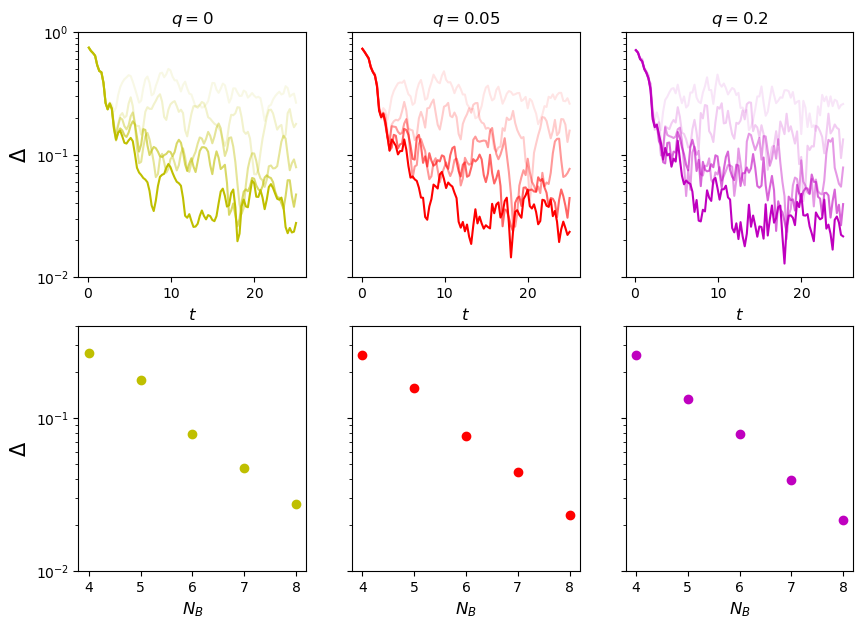

In [43]:
# Plot
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(10,7))

# distances for different N_B with time on a log scale
axes[0,0].plot(times, xi_sizes[0,0], color='y', alpha=0.1)
axes[0,0].plot(times, xi_sizes[1,0], color='y', alpha=0.2)
axes[0,0].plot(times, xi_sizes[2,0], color='y', alpha=0.4)
axes[0,0].plot(times, xi_sizes[3,0], color='y', alpha=0.6)
axes[0,0].plot(times, xi_sizes[4,0], color='y', alpha=1)
axes[0,0].set_yscale('log')
axes[0,0].set_ylim(0.01,1)
axes[0,0].set_ylabel('$\Delta$',size=15)
axes[0,0].set_xlabel('$t$',size=12)
axes[0,0].set_title('$q=0$')

axes[0,1].plot(times, xi_sizes[0,1], color='r', alpha=0.1)
axes[0,1].plot(times, xi_sizes[1,1], color='r', alpha=0.2)
axes[0,1].plot(times, xi_sizes[2,1], color='r', alpha=0.4)
axes[0,1].plot(times, xi_sizes[3,1], color='r', alpha=0.6)
axes[0,1].plot(times, xi_sizes[4,1], color='r', alpha=1)
axes[0,1].set_yscale('log')
axes[0,1].set_ylim(0.01,1)
axes[0,1].set_yticklabels('')
axes[0,1].set_xlabel('$t$',size=12)
axes[0,1].set_title('$q=0.05$')

axes[0,2].plot(times, xi_sizes[0,2], color='m', alpha=0.1)
axes[0,2].plot(times, xi_sizes[1,2], color='m', alpha=0.2)
axes[0,2].plot(times, xi_sizes[2,2], color='m', alpha=0.4)
axes[0,2].plot(times, xi_sizes[3,2], color='m', alpha=0.6)
axes[0,2].plot(times, xi_sizes[4,2], color='m', alpha=1)
axes[0,2].set_yscale('log')
axes[0,2].set_ylim(0.01,1)
axes[0,2].set_yticklabels('')
axes[0,2].set_xlabel('$t$',size=12)
axes[0,2].set_title('$q=0.2$')

# Late time scaling of distance with N_B, as well as comparison with Haar ensemble, again for three moments
axes[1,0].plot(N_Bs, xi_sizes[:,0,-1], 'yo')
axes[1,0].set_yscale('log')
axes[1,0].set_ylim(0.01,0.4)
axes[1,0].set_ylabel('$\Delta$',size=15)
axes[1,0].set_xlabel('$N_B$',size=12)

axes[1,1].plot(N_Bs, xi_sizes[:,1,-1], 'ro')
axes[1,1].set_yscale('log')
axes[1,1].set_ylim(0.01,0.4)
axes[1,1].set_yticklabels('')
axes[1,1].set_xlabel('$N_B$',size=12)


axes[1,2].plot(N_Bs, xi_sizes[:,2,-1], 'mo')
axes[1,2].set_yscale('log')
axes[1,2].set_ylim(0.01,0.4)
axes[1,2].set_yticklabels('')
axes[1,2].set_xlabel('$N_B$',size=12)

## $k=2$
For $k=2$, writing $S_2 = \{I, S \}$, I showed that the two coefficients $C_I$ and $C_S$ depend only on the second scalar moment or average purity
$\begin{equation}
P^{(2)}  = \sum_i p_i \text{Tr}[\rho_i^2].
\end{equation}$

I will again look at mixed ensembles with three different error probabilities $q$. I think I will calculate the average purity at every timestep, calculate the coefficients $c_I$ and $c_S$ from that and then find the rest term, meaning that I'm not comparing it to any fixed ensemble. But I will track maybe the late time purity to say something about the average ensemble everything is tending to.

In [5]:
# Identity (label 2 refers to the fact that its identity and swap in S_2)
def W_I_2(d):
    W_I = np.identity(d**2, dtype='complex128')
    return W_I

# Swap
def W_S_2(d):
    W_S = np.zeros((d**2,d**2),dtype='complex128')
    for i in range(d):
        for j in range(d):
            ket_i = np.zeros(d)
            ket_i [i] = 1
            ket_j = np.zeros(d)
            ket_j [j] = 1

            ket_ij = np.kron(ket_i, ket_j)
            ket_ji = np.kron(ket_j, ket_i)

            W_S += np.outer(np.conjugate(ket_ji), ket_ij)
    
    return W_S

def Purity(MixEns):
    purity = 0
    for i in range(len(MixEns)):
        p = MixEns[i][0]
        rho = MixEns[i][1]
        purity += p * np.trace(rho @ rho)

    return purity

def Channel(MixEns, d, W_I, W_S):
    P = Purity(MixEns)

    c_I = (1 - P / d) / (d ** 2 - 1)
    c_S = (P - 1 / d) / (d ** 2 - 1)

    return c_I * W_I + c_S * W_S


In [6]:
# We're storing data: times, purities, and sizes of the rest term xi
times = np.linspace(0.1,25,100)
# Shape: 5 values of N_B, three probabilities, for each time
purities = np.empty((5,3,np.size(times)))
xi_sizes = np.empty((5,3,np.size(times)))

# Fixed variables
N_A = 2
h_x = 0.8090
h_y = 0.9045
J = 1

d = 2 ** N_A
N_Bs = [4,5,6,7,8]

# Permutation basis states
W_I = W_I_2(d)
W_S = W_S_2(d)

for i, N_B in enumerate(N_Bs):
    # define Hamiltonian, get initial state
    H = QIMF(N_A + N_B, h_x, h_y, J)
    Psi0 = np.zeros(2 ** (N_A + N_B))
    Psi0[0] = 1

    for j, t in enumerate(times):
        # For each time, get quenched state and the projected ensemble
        U = expm(-t * 1j * H)
        Psi = U @ Psi0
        PrEns = Get_PrEns(Psi, N_A, N_B)
        
        # For each q, get mixed ensemble, find xi, get trace and purity
        MixEns = Get_MixEns(PrEns, N_A, N_B, 0)
        rho_2 = rho_MixEns(MixEns, 2)
        xi = rho_2 - Channel(MixEns, d, W_I, W_S)
        xi_sizes[i,0,j] = np.trace(xi @ xi) / np.trace(rho_2 @ rho_2)
        purities[i,0,j] = Purity(MixEns)

        MixEns = Get_MixEns(PrEns, N_A, N_B, 0.05)
        rho_2 = rho_MixEns(MixEns, 2)
        xi = rho_2 - Channel(MixEns, d, W_I, W_S)
        xi_sizes[i,1,j] = np.trace(xi @ xi) / np.trace(rho_2 @ rho_2)
        purities[i,1,j] = Purity(MixEns)

        MixEns = Get_MixEns(PrEns, N_A, N_B, 0.2)
        rho_2 = rho_MixEns(MixEns, 2)
        xi = rho_2 - Channel(MixEns, d, W_I, W_S)
        xi_sizes[i,2,j] = np.trace(xi @ xi) / np.trace(rho_2 @ rho_2)
        purities[i,2,j] = Purity(MixEns)

/var/folders/jp/3pg31pr14qv9d64r8h1jy0mc0000gn/T/ipykernel_21862/660433176.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  xi_sizes[i,0,j] = np.trace(xi @ xi) / np.trace(rho_2 @ rho_2)
/var/folders/jp/3pg31pr14qv9d64r8h1jy0mc0000gn/T/ipykernel_21862/660433176.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  purities[i,0,j] = Purity(MixEns)
/var/folders/jp/3pg31pr14qv9d64r8h1jy0mc0000gn/T/ipykernel_21862/660433176.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
  xi_sizes[i,1,j] = np.trace(xi @ xi) / np.trace(rho_2 @ rho_2)
/var/folders/jp/3pg31pr14qv9d64r8h1jy0mc0000gn/T/ipykernel_21862/660433176.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
  purities[i,1,j] = Purity(MixEns)
/var/folders/jp/3pg31pr14qv9d64r8h1jy0mc0000gn/T/ipykernel_21862/660433176.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  xi_sizes[i,2,j]

Text(0.5, 0, '$N_B$')

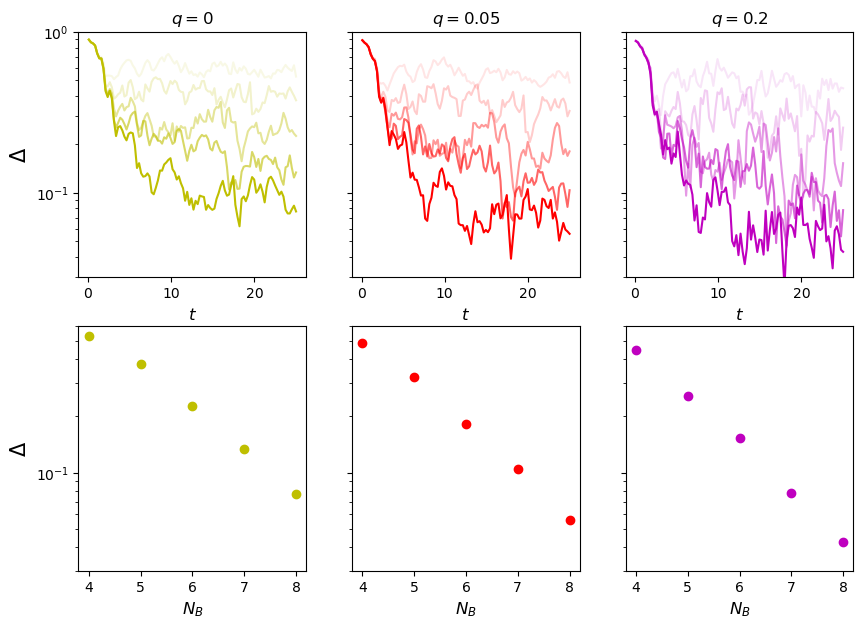

In [7]:
# Plot
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(10,7))

# distances for different N_B with time on a log scale
axes[0,0].plot(times, xi_sizes[0,0], color='y', alpha=0.1)
axes[0,0].plot(times, xi_sizes[1,0], color='y', alpha=0.2)
axes[0,0].plot(times, xi_sizes[2,0], color='y', alpha=0.4)
axes[0,0].plot(times, xi_sizes[3,0], color='y', alpha=0.6)
axes[0,0].plot(times, xi_sizes[4,0], color='y', alpha=1)
axes[0,0].set_yscale('log')
axes[0,0].set_ylim(0.03,1)
axes[0,0].set_ylabel('$\Delta$',size=15)
axes[0,0].set_xlabel('$t$',size=12)
axes[0,0].set_title('$q=0$')

axes[0,1].plot(times, xi_sizes[0,1], color='r', alpha=0.1)
axes[0,1].plot(times, xi_sizes[1,1], color='r', alpha=0.2)
axes[0,1].plot(times, xi_sizes[2,1], color='r', alpha=0.4)
axes[0,1].plot(times, xi_sizes[3,1], color='r', alpha=0.6)
axes[0,1].plot(times, xi_sizes[4,1], color='r', alpha=1)
axes[0,1].set_yscale('log')
axes[0,1].set_ylim(0.03,1)
axes[0,1].set_yticklabels('')
axes[0,1].set_xlabel('$t$',size=12)
axes[0,1].set_title('$q=0.05$')

axes[0,2].plot(times, xi_sizes[0,2], color='m', alpha=0.1)
axes[0,2].plot(times, xi_sizes[1,2], color='m', alpha=0.2)
axes[0,2].plot(times, xi_sizes[2,2], color='m', alpha=0.4)
axes[0,2].plot(times, xi_sizes[3,2], color='m', alpha=0.6)
axes[0,2].plot(times, xi_sizes[4,2], color='m', alpha=1)
axes[0,2].set_yscale('log')
axes[0,2].set_ylim(0.03,1)
axes[0,2].set_yticklabels('')
axes[0,2].set_xlabel('$t$',size=12)
axes[0,2].set_title('$q=0.2$')

# Late time scaling of distance with N_B, as well as comparison with Haar ensemble, again for three moments
axes[1,0].plot(N_Bs, xi_sizes[:,0,-1], 'yo')
axes[1,0].set_yscale('log')
axes[1,0].set_ylim(0.03,0.6)
axes[1,0].set_ylabel('$\Delta$',size=15)
axes[1,0].set_xlabel('$N_B$',size=12)

axes[1,1].plot(N_Bs, xi_sizes[:,1,-1], 'ro')
axes[1,1].set_yscale('log')
axes[1,1].set_ylim(0.03,0.6)
axes[1,1].set_yticklabels('')
axes[1,1].set_xlabel('$N_B$',size=12)


axes[1,2].plot(N_Bs, xi_sizes[:,2,-1], 'mo')
axes[1,2].set_yscale('log')
axes[1,2].set_ylim(0.03,0.6)
axes[1,2].set_yticklabels('')
axes[1,2].set_xlabel('$N_B$',size=12)

### Purities
Here I look at how the average purity (the only input into the coefficients $c_I$ and $c_S$) changes with time for mixed ensembles derived from quenched states. I compare it with the purity of the new ensemble.

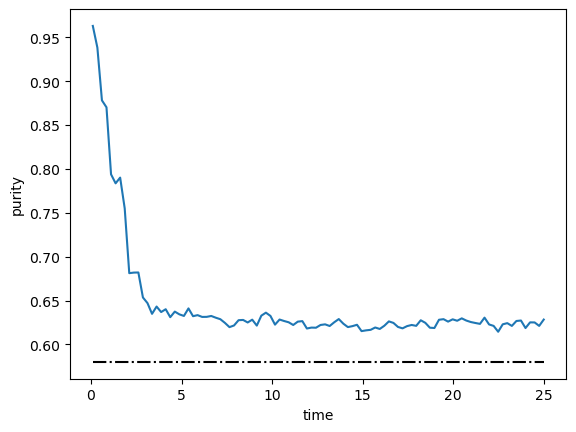

In [31]:
q = 0.05
i = 4
N_B = N_Bs[i]
r = 1 - (1-q) ** N_B
new_purity = (1-r) ** 2 + r * (2-r) / d
fig = plt.figure()
plt.plot(times,purities[i,1])
plt.plot(times, [new_purity for j in range(len(times))], 'k-.')
plt.ylabel('purity')
plt.xlabel('time')
plt.show()

## Schur-Weyl analysis for integrable system
Below a check: not all systems have a decaying term $\xi$. For the integrable Transverse Field Ising Model the relative size of $\xi$ as given by $\Delta$ remains large with time, and shows no pattern with increasing $N_B$.

In [93]:
# We're storing data: times, purities, and sizes of the rest term xi
times = np.linspace(0.1,25,50)
# Shape: 5 values of N_B, three probabilities, for each time
purities = np.empty((5,3,np.size(times)))
xi_sizes = np.empty((5,3,np.size(times)))

# Fixed variables
N_A = 2
h_x = 0
h_y = 0.9045
J = 1

d = 2 ** N_A
N_Bs = [4,5,6,7,8]

# Permutation basis states
W_I = W_I_2(d)
W_S = W_S_2(d)

for i, N_B in enumerate(N_Bs):
    # define Hamiltonian, get initial state
    H = QIMF(N_A + N_B, h_x, h_y, J)
    Psi0 = np.zeros(2 ** (N_A + N_B))
    Psi0[0] = 1

    for j, t in enumerate(times):
        # For each time, get quenched state and the projected ensemble
        U = expm(-t * 1j * H)
        Psi = U @ Psi0
        PrEns = Get_PrEns(Psi, N_A, N_B)
        
        # For each q, get mixed ensemble, find xi, get trace and purity
        MixEns = Get_MixEns(PrEns, N_A, N_B, 0)
        rho_2 = rho_MixEns(MixEns, 2)
        xi = rho_2 - Channel(MixEns, d, W_I, W_S)
        xi_sizes[i,0,j] = np.trace(xi @ xi) / np.trace(rho_2 @ rho_2)
        purities[i,0,j] = Purity(MixEns)

        MixEns = Get_MixEns(PrEns, N_A, N_B, 0.05)
        rho_2 = rho_MixEns(MixEns, 2)
        xi = rho_2 - Channel(MixEns, d, W_I, W_S)
        xi_sizes[i,1,j] = np.trace(xi @ xi) / np.trace(rho_2 @ rho_2)
        purities[i,1,j] = Purity(MixEns)

        MixEns = Get_MixEns(PrEns, N_A, N_B, 0.2)
        rho_2 = rho_MixEns(MixEns, 2)
        xi = rho_2 - Channel(MixEns, d, W_I, W_S)
        xi_sizes[i,2,j] = np.trace(xi @ xi) / np.trace(rho_2 @ rho_2)
        purities[i,2,j] = Purity(MixEns)

/var/folders/jp/3pg31pr14qv9d64r8h1jy0mc0000gn/T/ipykernel_9780/3774948704.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  xi_sizes[i,0,j] = np.trace(xi @ xi) / np.trace(rho_2 @ rho_2)
/var/folders/jp/3pg31pr14qv9d64r8h1jy0mc0000gn/T/ipykernel_9780/3774948704.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  purities[i,0,j] = Purity(MixEns)
/var/folders/jp/3pg31pr14qv9d64r8h1jy0mc0000gn/T/ipykernel_9780/3774948704.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
  xi_sizes[i,1,j] = np.trace(xi @ xi) / np.trace(rho_2 @ rho_2)
/var/folders/jp/3pg31pr14qv9d64r8h1jy0mc0000gn/T/ipykernel_9780/3774948704.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
  purities[i,1,j] = Purity(MixEns)
/var/folders/jp/3pg31pr14qv9d64r8h1jy0mc0000gn/T/ipykernel_9780/3774948704.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  xi_sizes[i,2,j]

Text(0.5, 0, '$N_B$')

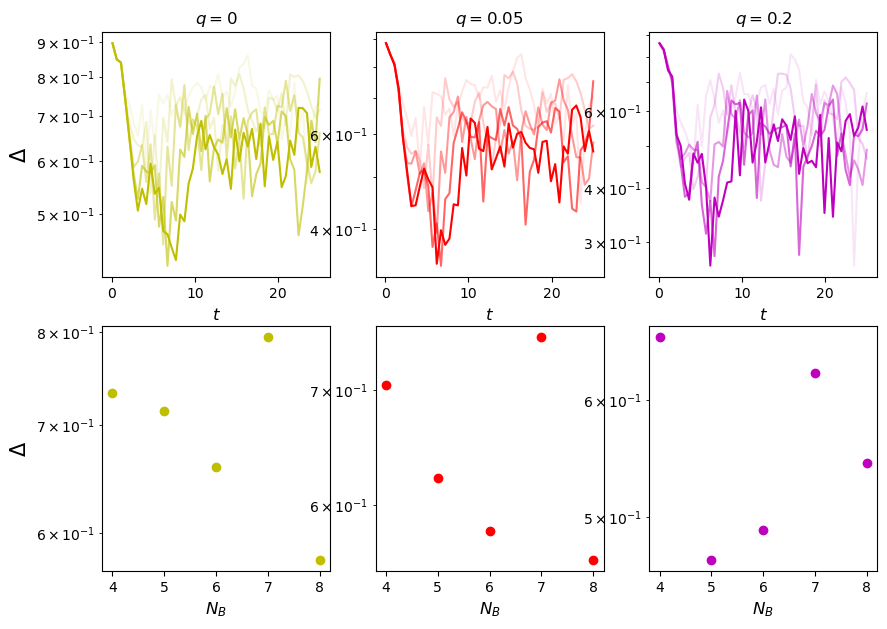

In [95]:
# Plot
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(10,7))

# distances for different N_B with time on a log scale
axes[0,0].plot(times, xi_sizes[0,0], color='y', alpha=0.1)
axes[0,0].plot(times, xi_sizes[1,0], color='y', alpha=0.2)
axes[0,0].plot(times, xi_sizes[2,0], color='y', alpha=0.4)
axes[0,0].plot(times, xi_sizes[3,0], color='y', alpha=0.6)
axes[0,0].plot(times, xi_sizes[4,0], color='y', alpha=1)
axes[0,0].set_yscale('log')
#axes[0,0].set_ylim(0.03,1)
axes[0,0].set_ylabel('$\Delta$',size=15)
axes[0,0].set_xlabel('$t$',size=12)
axes[0,0].set_title('$q=0$')

axes[0,1].plot(times, xi_sizes[0,1], color='r', alpha=0.1)
axes[0,1].plot(times, xi_sizes[1,1], color='r', alpha=0.2)
axes[0,1].plot(times, xi_sizes[2,1], color='r', alpha=0.4)
axes[0,1].plot(times, xi_sizes[3,1], color='r', alpha=0.6)
axes[0,1].plot(times, xi_sizes[4,1], color='r', alpha=1)
axes[0,1].set_yscale('log')
#axes[0,1].set_ylim(0.03,1)
axes[0,1].set_yticklabels('')
axes[0,1].set_xlabel('$t$',size=12)
axes[0,1].set_title('$q=0.05$')

axes[0,2].plot(times, xi_sizes[0,2], color='m', alpha=0.1)
axes[0,2].plot(times, xi_sizes[1,2], color='m', alpha=0.2)
axes[0,2].plot(times, xi_sizes[2,2], color='m', alpha=0.4)
axes[0,2].plot(times, xi_sizes[3,2], color='m', alpha=0.6)
axes[0,2].plot(times, xi_sizes[4,2], color='m', alpha=1)
axes[0,2].set_yscale('log')
#axes[0,2].set_ylim(0.03,1)
axes[0,2].set_yticklabels('')
axes[0,2].set_xlabel('$t$',size=12)
axes[0,2].set_title('$q=0.2$')

# Late time scaling of distance with N_B, as well as comparison with Haar ensemble, again for three moments
axes[1,0].plot(N_Bs, xi_sizes[:,0,-1], 'yo')
axes[1,0].set_yscale('log')
#axes[1,0].set_ylim(0.03,0.6)
axes[1,0].set_ylabel('$\Delta$',size=15)
axes[1,0].set_xlabel('$N_B$',size=12)

axes[1,1].plot(N_Bs, xi_sizes[:,1,-1], 'ro')
axes[1,1].set_yscale('log')
#axes[1,1].set_ylim(0.03,0.6)
axes[1,1].set_yticklabels('')
axes[1,1].set_xlabel('$N_B$',size=12)


axes[1,2].plot(N_Bs, xi_sizes[:,2,-1], 'mo')
axes[1,2].set_yscale('log')
#axes[1,2].set_ylim(0.03,0.6)
axes[1,2].set_yticklabels('')
axes[1,2].set_xlabel('$N_B$',size=12)